# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import OrdinalEncoder, Binarizer

# set style
sns.set(style='whitegrid', palette='pastel')
pd.set_option('display.max_colwidth', None)

In [5]:
# importing and assigning simplified names
try:
    final_df = pd.read_csv('data/olist_final.csv')
except FileNotFoundError:
    print("Try to change the file directories/names")

# Final DF Inspection
inspecting the data to ensure correct import

In [3]:
print(final_df.shape, '\n--------------------')
print(final_df.head().to_string())

(92732, 28) 
--------------------
                 customer_unique_id weekday_<lambda>  hour_median  price_sum  price_mean  freight_value_mean payment_type_<lambda>  payment_installments_mean  payment_value_sum  payment_value_mean  review_score_mean  product_photos_qty_mean  product_weight_g_mean  product_length_cm_mean  product_height_cm_mean  product_width_cm_mean customer_city_<lambda> customer_state_<lambda>  geolocation_lat_mean  geolocation_lng_mean season_<lambda>  delivery_time_mean product_category_name_english  order_count  repeat_buyer  distinct_product_categories  months_inactive  avg_distance_km
0  0000366f3b9a7992bf8c76cfdf3221e2         Thursday         10.0     129.90      129.90               12.00           credit_card                        8.0             141.90              141.90                5.0                      1.0                 1500.0                    34.0                     7.0                   32.0                cajamar                      SP   

# Eval and Data Functions for Models

In [6]:
def data_splitter(features, target, stratify=True, num_process=StandardScaler(), cat_process=OneHotEncoder(handle_unknown='ignore')):
    # Separate features and target
    X = final_df[features]
    y = final_df[target]

    # Detect categorical columns (object type)
    categorical_cols = X.select_dtypes(include='object').columns.tolist()
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('num', num_process, numeric_cols),
        ('cat', cat_process, categorical_cols)
    ])

    # Transform the data
    X_processed = preprocessor.fit_transform(X)
    
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size=0.2, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [7]:
def metrics_eval(model):
    # get classes
    pred_classes = model.predict(X_test)
    true_classes = y_test

    # init confusion matrix
    cm = confusion_matrix(true_classes, pred_classes)
    tn, fp, fn, tp = confusion_matrix(true_classes, pred_classes).ravel()

    # custom metric calculations
    accuracy = accuracy_score(true_classes, pred_classes)
    precision = precision_score(true_classes, pred_classes, average='weighted')
    recall = recall_score(true_classes, pred_classes, average='weighted')
    f1 = f1_score(true_classes, pred_classes, average='weighted')
    specificity = tn / (tn+fp)

    # display results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")

    sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r',
                xticklabels=np.unique(true_classes),
                yticklabels=np.unique(true_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [8]:
def rocauc_eval(model):
    preds = model.predict_proba(X_test)
    true_labels = y_test

    plt.figure()
    lw = 2
    roc_colours = ['red', 'blue']
    roc_labels = ['Repeat', 'Non-Repeat']

    for i in range(2):
        scores = preds[:, i]
        fpr, tpr, _ = roc_curve(true_labels == i, scores)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=roc_colours[i], lw=lw, label=f'{roc_labels[i]}(area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    plt.plot([0, 1], [1, 1], color='gray', lw=lw, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics: One-vs-Rest')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def gridcv_tree(param_grid):
  grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid, scoring='accuracy', n_jobs=-1)
  grid_tree.fit(X_train, y_train)

  print('Best parameters is:', grid_tree.best_params_)
  print('Parameters: ', grid_tree.best_estimator_.get_params())
  metrics_eval(grid_tree)
  rocauc_eval(grid_tree)

  return grid_tree.best_estimator_

In [10]:
def cont_eval(model, title, x_size, y_size):
    y_pred = model.predict(X_test)

    print("test mae: ", mean_absolute_error(y_test, model.predict((X_test))) * -1)
    print("train mae: ", mean_absolute_error(y_train, model.predict((X_train))) * -1)
    print("--------------------------")
    print("test mse: ", mean_squared_error(y_test, model.predict((X_test))) * -1)
    print("train mse: ", mean_squared_error(y_train, model.predict((X_train))) * -1)
    print("--------------------------")
    print("test r2: ", r2_score(y_test, model.predict((X_test))))
    print("train r2: ", r2_score(y_train, model.predict((X_train))))
    print("--------------------------")

    sns.set_palette('hls')
    plt.scatter(y_pred, y_test, alpha=0.2)
    plt.plot([0, x_size], [0, y_size], color="cornflowerblue", lw=2)
    plt.xlabel('Predicted Value')
    plt.ylabel('True Value')
    plt.title(title)
    plt.xlim(0, x_size)
    plt.ylim(0, y_size)
    plt.show()

In [11]:
def randomcv_cont(model, param_dist):
  random_tree = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
  )
  random_tree.fit(X_train, y_train)

  return random_tree.best_estimator_, random_tree

In [12]:
def feature_imp(model, features):
    # Assuming X_processed is a DataFrame
    importances = model.feature_importances_

    # filter and sort features
    filtered_indices = [i for i, name in enumerate(features)]
    filtered_names = [features[i] for i in filtered_indices]
    filtered_importances = [importances[i] for i in filtered_indices]

    sorted_idx = np.argsort(filtered_importances)[::-1]
    sorted_names = [filtered_names[i] for i in sorted_idx]
    sorted_importances = [filtered_importances[i] for i in sorted_idx]

    plt.bar(range(len(sorted_importances)), sorted_importances)
    plt.title("Feature Importances")
    plt.xticks(range(len(sorted_importances)), sorted_names, rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

# ML Model for Repeat Buyers

In [112]:
print(final_df.head().to_string())
print(final_df.columns)

                 customer_unique_id weekday_<lambda>  hour_median  price_sum  price_mean  freight_value_mean payment_type_<lambda>  payment_installments_mean  payment_value_sum  payment_value_mean  review_score_mean  product_photos_qty_mean  product_weight_g_mean  product_length_cm_mean  product_height_cm_mean  product_width_cm_mean customer_city_<lambda> customer_state_<lambda>  geolocation_lat_mean  geolocation_lng_mean season_<lambda>  delivery_time_mean product_category_name_english  order_count  repeat_buyer  distinct_product_categories  months_inactive  avg_distance_km
0  0000366f3b9a7992bf8c76cfdf3221e2         Thursday         10.0     129.90      129.90               12.00           credit_card                        8.0             141.90              141.90                5.0                      1.0                 1500.0                    34.0                     7.0                   32.0                cajamar                      SP            -23.340235            -46

In [113]:
selected_X = ['weekday_<lambda>', 'hour_median', 'price_sum', 'price_mean', 'payment_type_<lambda>',
               'payment_installments_mean', 'payment_value_sum', 'payment_value_mean', 'review_score_mean',
                 'product_photos_qty_mean', 'delivery_time_mean', 'distinct_product_categories']
X_train, X_test, y_train, y_test = data_splitter(selected_X, 'repeat_buyer')

In [66]:
repeat_tree1 = DecisionTreeClassifier(max_depth=6, max_features=3, min_samples_leaf=3,
                                      min_samples_split=3, splitter='best', random_state=42, class_weight='balanced')
repeat_tree1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_features=3,
                       min_samples_leaf=3, min_samples_split=3,
                       random_state=42)

Accuracy: 0.9680
Precision: 0.9706
Recall: 0.9680
F1 Score: 0.9692
Specificity: 0.9809


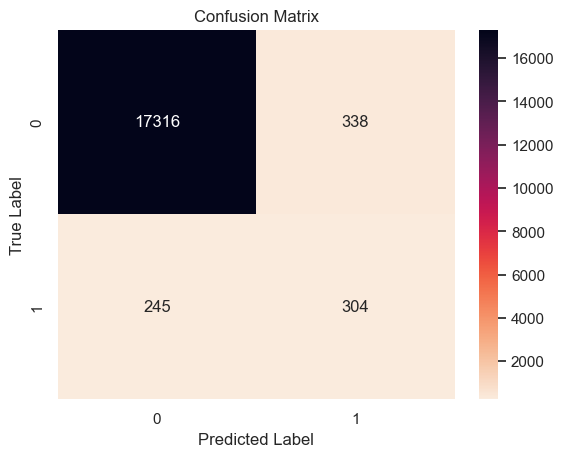

In [67]:
metrics_eval(repeat_tree1)

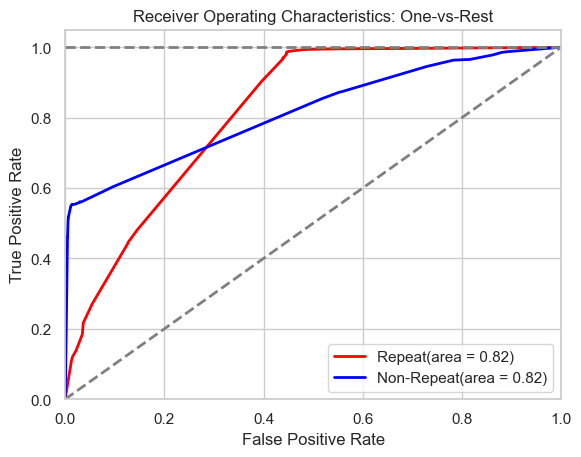

In [68]:
rocauc_eval(repeat_tree1)

# Repeat Buyers Optimization:
optimizing the model using features like gridsearch

c:\Users\cryp1\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters is: {'max_depth': 9, 'max_features': 14, 'min_samples_leaf': 2, 'min_samples_split': 7, 'splitter': 'best'}
Parameters:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 14, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
Accuracy: 0.9929
Precision: 0.9929
Recall: 0.9929
F1 Score: 0.9929
Specificity: 0.9966


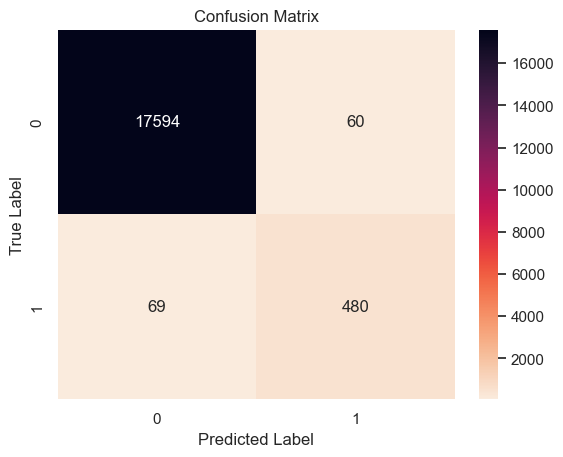

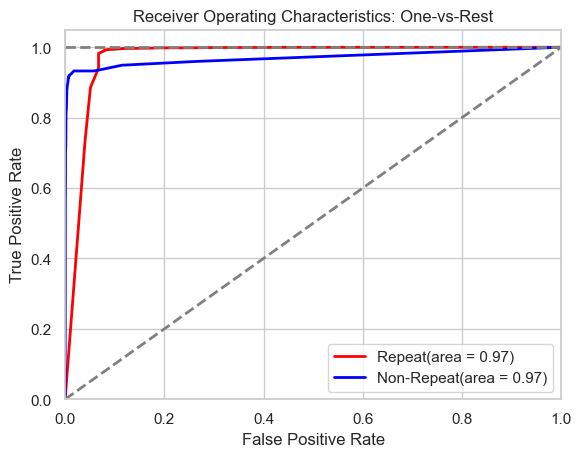

In [69]:
# define search range
param_grid = {'max_depth': list(range(7, 11)), 'splitter': ['best', 'random'],
'max_features': range(12, 15), 'min_samples_leaf': range(1, 4), 'min_samples_split': range(5, 9)}

# repeat buyer: rb
repeat_treegrid1 = gridcv_tree(param_grid)

# SKLearn Model for freight value

In [13]:
print(final_df.head().to_string())

                 customer_unique_id weekday_<lambda>  hour_median  price_sum  price_mean  freight_value_mean payment_type_<lambda>  payment_installments_mean  payment_value_sum  payment_value_mean  review_score_mean  product_photos_qty_mean  product_weight_g_mean  product_length_cm_mean  product_height_cm_mean  product_width_cm_mean customer_city_<lambda> customer_state_<lambda>  geolocation_lat_mean  geolocation_lng_mean season_<lambda>  delivery_time_mean product_category_name_english  order_count  repeat_buyer  distinct_product_categories  months_inactive  avg_distance_km
0  0000366f3b9a7992bf8c76cfdf3221e2         Thursday         10.0     129.90      129.90               12.00           credit_card                        8.0             141.90              141.90                5.0                      1.0                 1500.0                    34.0                     7.0                   32.0                cajamar                      SP            -23.340235            -46

In [14]:
print(final_df['freight_value_mean'].describe())

count    91013.000000
mean        20.204764
std         15.740062
min          0.000000
25%         13.370000
50%         16.420000
75%         21.220000
max        409.680000
Name: freight_value_mean, dtype: float64


In [19]:
selected_X = ['hour_median', 'price_mean', 'geolocation_lat_mean', 'avg_distance_km',
              'geolocation_lng_mean', 'product_weight_g_mean', 'product_length_cm_mean',
              'product_height_cm_mean', 'product_width_cm_mean', 'volume_mean', 'delivery_time_mean']
X_train, X_test, y_train, y_test = data_splitter(selected_X, 'freight_value_mean', stratify=False)

In [20]:
freight_linmodel1 = LinearRegression()
freight_linmodel1.fit(X_train, y_train)
print(freight_linmodel1.score(X_test, y_test))

0.6196754578594268


test mae:  -5.028533740495004
train mae:  -5.104391193492933
--------------------------
test mse:  -89.2654588718568
train mse:  -97.47929914879343
--------------------------
test r2:  0.6196754578594268
train r2:  0.6116241208087554
--------------------------


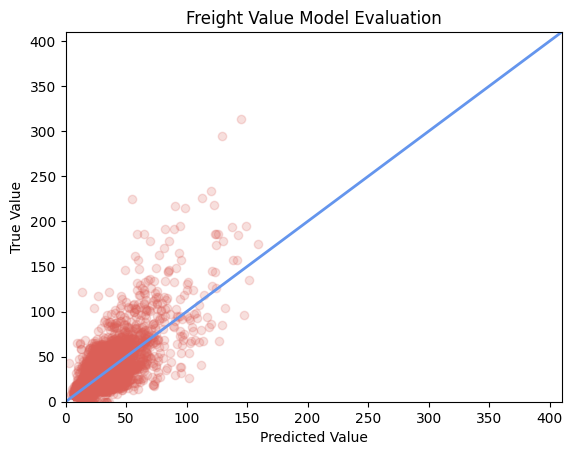

In [21]:
cont_eval(freight_linmodel1, 'Freight Value Model Evaluation', 410, 410)

test mae:  -5.60696533823816
train mae:  -5.534955711428549
--------------------------
test mse:  -105.96524319171186
train mse:  -96.8411776791679
--------------------------
test r2:  0.5485243328267002
train r2:  0.6141665168760304
--------------------------


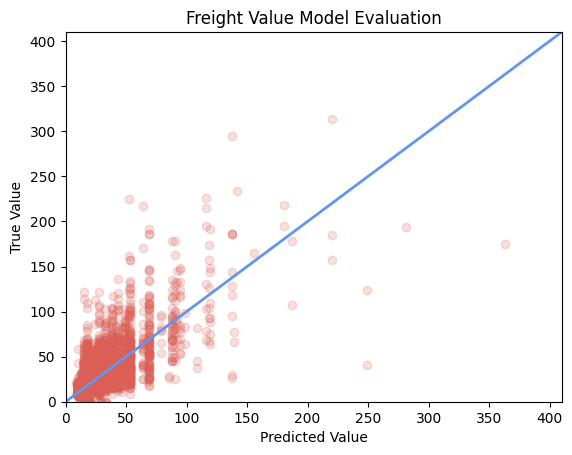

In [22]:
freight_treemodel1 = DecisionTreeRegressor(max_depth=6, max_features=3, min_samples_leaf=3, 
                                          min_samples_split=3, splitter='best', random_state=42)
freight_treemodel1.fit(X_train, y_train)
cont_eval(freight_treemodel1, 'Freight Value Model Evaluation', 410, 410)

# Optimizing the model with various techniques
Utilizing RandomizedSearchCV, ensemble models, feature importance selection

In [24]:
selected_X = ['hour_median', 'price_sum', 'price_mean', 'geolocation_lat_mean',
              'geolocation_lng_mean', 'product_weight_g_mean', 'product_length_cm_mean',
              'product_height_cm_mean', 'product_width_cm_mean', 'volume_mean', 'delivery_time_mean',
              'cost_volume', 'density_mean', 'cost_weight', 'lh_ratio', 'lw_ratio', 'hw_ratio']
X_train, X_test, y_train, y_test = data_splitter(selected_X, 'freight_value_mean', stratify=False,
                                                 cat_process=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 2, 'max_depth': 5, 'learning_rate': 0.5}
best mae from grid: -4.71730669676063
test mae:  -4.602487173324987
train mae:  -4.506608393605803
--------------------------
test mse:  -85.52985371041723
train mse:  -90.88242228155025
--------------------------
test r2:  0.6355913825698121
train r2:  0.6379073201711265
--------------------------


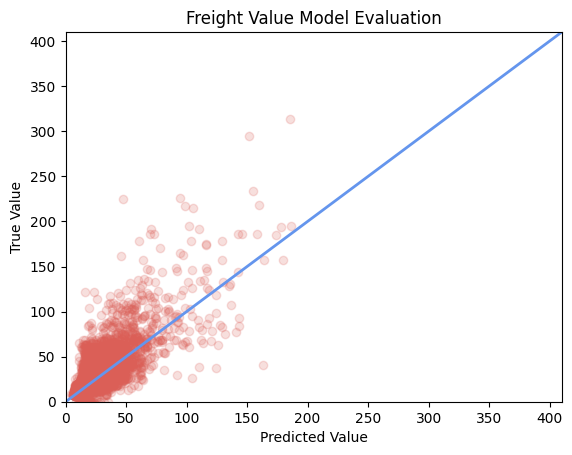

In [25]:
param_dist = {
    "max_depth": range(5, 7),
    "max_features": range(1, 3),
    "min_samples_leaf": range(1, 3),
    "min_samples_split": range(2, 4),
    "n_estimators": [10, 20, 30],
    "learning_rate": [0.05, 0.1, 0.5]
}
gb_reg1, random_reg = randomcv_cont(GradientBoostingRegressor(random_state=42, loss='absolute_error'), param_dist)
print(random_reg.best_params_)
print("best mae from grid:", random_reg.best_score_)
cont_eval(gb_reg1, 'Freight Value Model Evaluation', 410, 410)

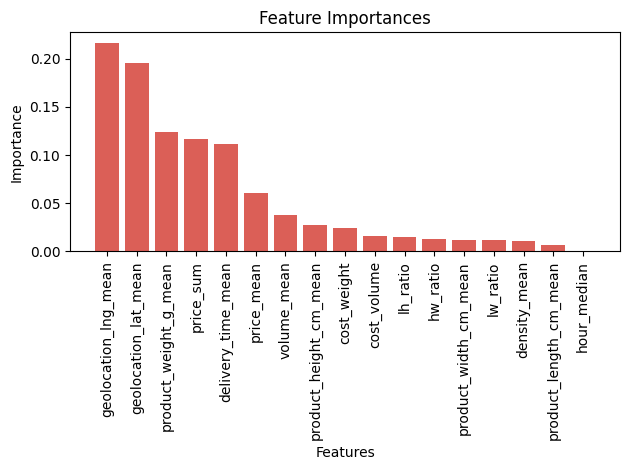

In [26]:
feature_imp(gb_reg1, selected_X)

In [27]:
selected_X = [
    'price_mean', 'price_sum', 'geolocation_lat_mean', 'geolocation_lng_mean',
    'product_weight_g_mean', 'volume_mean',
    'weekday_<lambda>', 'season_<lambda>', 'delivery_time_mean'
]
X_train, X_test, y_train, y_test = data_splitter(selected_X, 'freight_value_mean', stratify=False,
                                                  cat_process=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'n_estimators': 86, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 7, 'max_depth': 8, 'learning_rate': 0.22}
best mae from grid: -4.209689105805993
test mae:  -4.080474391273609
train mae:  -3.6017138582470545
--------------------------
test mse:  -76.63621396322257
train mse:  -65.56768031508314
--------------------------
test r2:  0.6734836368366124
train r2:  0.7387660179005701
--------------------------


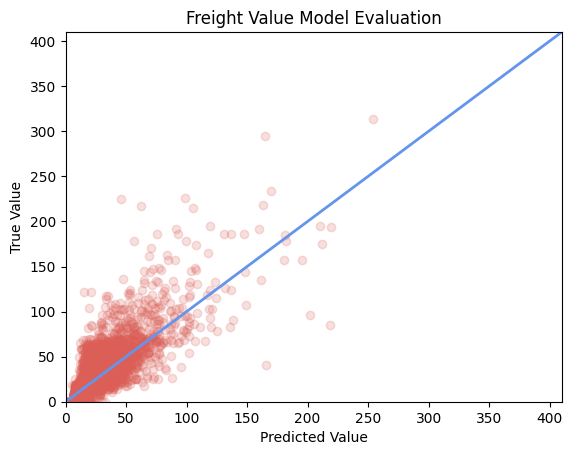

In [28]:
param_dist = {
    "max_depth": range(5, 9),
    "max_features": range(5, len(selected_X)),
    "min_samples_leaf": range(2, 4),
    "min_samples_split": range(2, 4),
    "n_estimators": [76, 86],
    "learning_rate": [0.2, 0.22, 0.25]
}
gb_reg2, random_reg = randomcv_cont(GradientBoostingRegressor(random_state=42, loss='absolute_error'), param_dist)
print(random_reg.best_params_)
print("best mae from grid:", random_reg.best_score_)
cont_eval(gb_reg2, 'Freight Value Model Evaluation', 410, 410)

test mae:  -4.080474391273609
train mae:  -3.6017138582470545
--------------------------
test mse:  -76.63621396322257
train mse:  -65.56768031508314
--------------------------
test r2:  0.6734836368366124
train r2:  0.7387660179005701
--------------------------


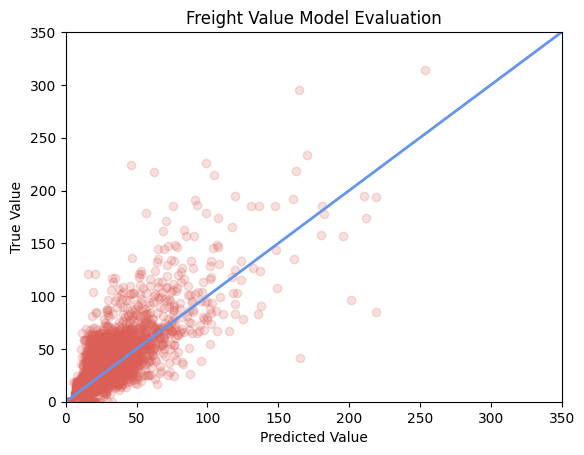

In [29]:
gb_reg3 = GradientBoostingRegressor(random_state=42, loss='absolute_error', max_depth=8,
                                     max_features=7, min_samples_leaf=3, min_samples_split=2,
                                       n_estimators=86, learning_rate=0.22)
gb_reg3.fit(X_train, y_train)
cont_eval(gb_reg3, 'Freight Value Model Evaluation', 350, 350)

# SKLearn ML model for Delivery Time

In [30]:
print(final_df.head().to_string())
print(final_df.columns)

                 customer_unique_id weekday_<lambda>  hour_median  price_sum  price_mean  freight_value_mean payment_type_<lambda>  payment_installments_mean  payment_value_sum  payment_value_mean  review_score_mean  product_photos_qty_mean  product_weight_g_mean  product_length_cm_mean  product_height_cm_mean  product_width_cm_mean customer_city_<lambda> customer_state_<lambda>  geolocation_lat_mean  geolocation_lng_mean season_<lambda>  delivery_time_mean product_category_name_english  order_count  repeat_buyer  distinct_product_categories  months_inactive  avg_distance_km  volume_mean  cost_volume  density_mean  cost_weight  lh_ratio  lw_ratio  hw_ratio
0  0000366f3b9a7992bf8c76cfdf3221e2         Thursday         10.0     129.90      129.90               12.00           credit_card                        8.0             141.90              141.90                5.0                      1.0                 1500.0                    34.0                     7.0                   32.0 

count    91013.000000
mean        12.047662
std          9.457407
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        208.000000
Name: delivery_time_mean, dtype: float64


[]

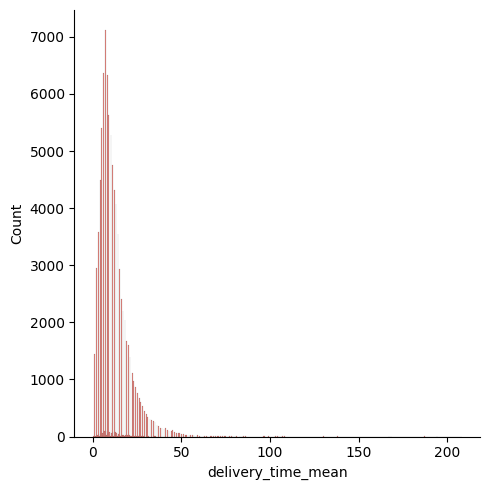

In [31]:
print(final_df['delivery_time_mean'].describe())
sns.displot(final_df['delivery_time_mean'])
plt.plot()

In [32]:
selected_X = ['weekday_<lambda>', 'hour_median', 'price_mean', 'freight_value_mean',
              'product_weight_g_mean', 'product_length_cm_mean', 'product_height_cm_mean',
              'product_width_cm_mean', 'customer_city_<lambda>', 'customer_state_<lambda>',
              'geolocation_lat_mean', 'geolocation_lng_mean', 'season_<lambda>', 'avg_distance_km',
              'volume_mean']
X_train, X_test, y_train, y_test = data_splitter(selected_X, 'delivery_time_mean', stratify=False,
                                                  cat_process=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))

test mae:  -5.206309718266556
train mae:  -5.190964106550015
--------------------------
test mse:  -67.90330598009926
train mse:  -67.87922109174474
--------------------------
test r2:  0.2348879228125864
train r2:  0.24254058288571423
--------------------------


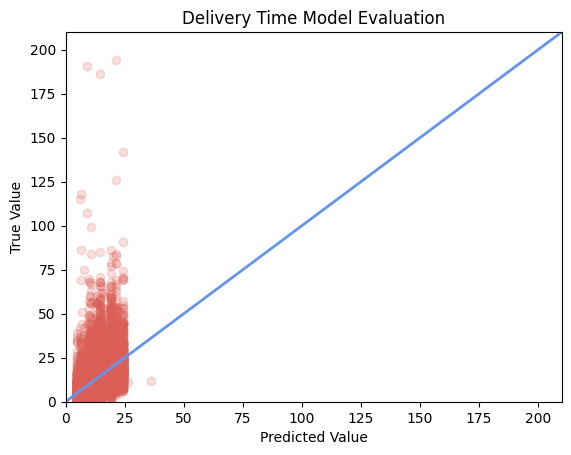

In [33]:
delivery_treemodel1 = DecisionTreeRegressor(max_depth=6, max_features=3, min_samples_leaf=3, 
                                          min_samples_split=3, splitter='best', random_state=42)
delivery_treemodel1.fit(X_train, y_train)
cont_eval(delivery_treemodel1, 'Delivery Time Model Evaluation', 210, 210)

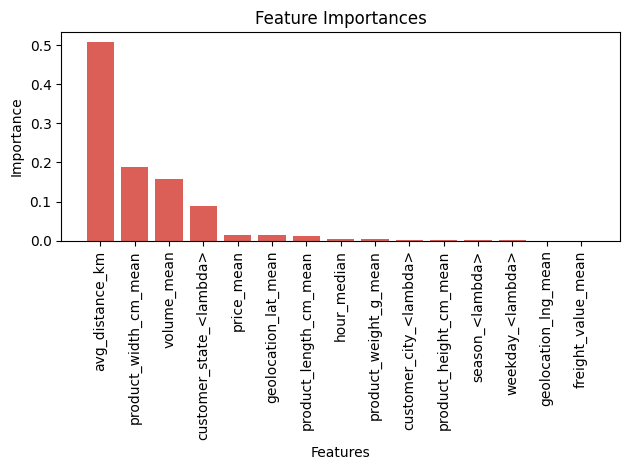

In [34]:
feature_imp(delivery_treemodel1, selected_X)

In [35]:
selected_X = ['weekday_<lambda>', 'hour_median', 'price_mean', 'freight_value_mean',
              'product_weight_g_mean', 'customer_city_<lambda>', 'customer_state_<lambda>',
              'geolocation_lat_mean', 'geolocation_lng_mean', 'avg_distance_km']
X_train, X_test, y_train, y_test = data_splitter(selected_X, 'delivery_time_mean', stratify=False,
                                                  cat_process=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 3, 'max_depth': 5, 'learning_rate': 0.3}
best mae from grid: -4.893386486500151
test mae:  -4.869895135246041
train mae:  -4.745360780857376
--------------------------
test mse:  -71.6435839585851
train mse:  -70.54798259664032
--------------------------
test r2:  0.192743702997776
train r2:  0.21276006240532974
--------------------------


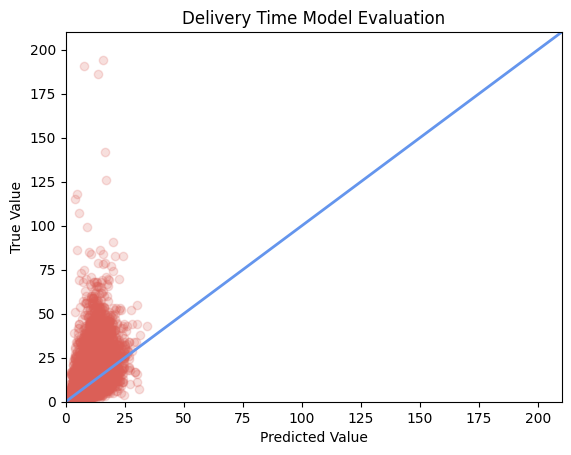

In [36]:
param_dist = {
    "max_depth": range(4, 7),
    "max_features": range(1, 4),
    "min_samples_leaf": range(1, 3),
    "min_samples_split": range(2, 4),
    "n_estimators": [35, 40, 50],
    "learning_rate": [0.2, 0.3, 0.5]
}

delivery_gbreg1, delivery_randomcv1 = randomcv_cont(GradientBoostingRegressor(random_state=42, loss='absolute_error'), param_dist)
print(delivery_randomcv1.best_params_)
print("best mae from grid:", delivery_randomcv1.best_score_)
cont_eval(delivery_gbreg1, 'Delivery Time Model Evaluation', 210, 210)

test mae:  -4.869895135246041
train mae:  -4.745360780857376
--------------------------
test mse:  -71.6435839585851
train mse:  -70.54798259664032
--------------------------
test r2:  0.192743702997776
train r2:  0.21276006240532974
--------------------------


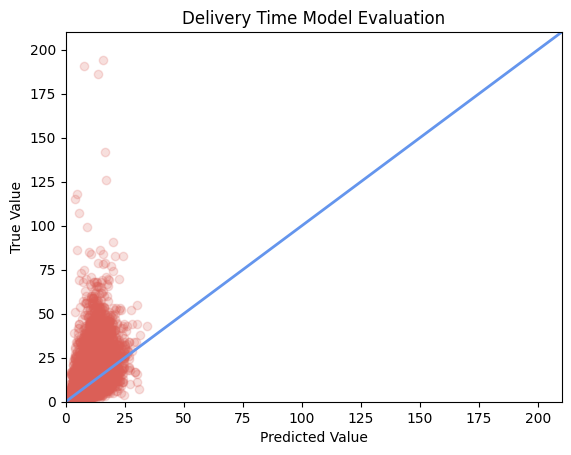

In [39]:
delivery_gbreg2 = GradientBoostingRegressor(n_estimators=50, min_samples_split=3, min_samples_leaf=2,
                                            max_features=3, max_depth=5, learning_rate=0.3,
                                            random_state=42, loss='absolute_error')
delivery_gbreg2.fit(X_train, y_train)
cont_eval(delivery_gbreg2, 'Delivery Time Model Evaluation', 210, 210)

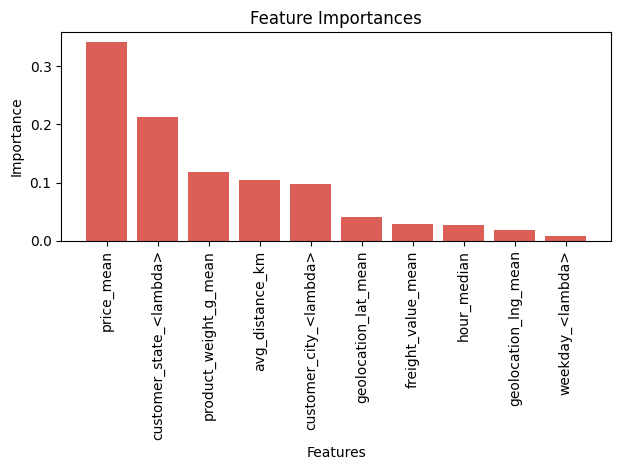

In [40]:
feature_imp(delivery_gbreg2, selected_X)

# ML Modelling Conclusions
Repeat Buyers Model:
Training was relatively easy for the repeat buyers column, achieving an incredibly high training and testing accuracy. However, the 100% accuracies may be due to the small size of the data. 

Freight Value Model:
Training was significantly difficult for freight value mean column compared to the repeat buyers column. It required the utilization of various different techniques like grid search, randomized search, feature importance, careful and logical feature selection and multiple iterations that are not present within this file to maintain it's small size.

Delivery Time Model:
Training was not as difficult for delivery time mean column compared to the freight value mean column. Many of the existing techniques present for the freight value model could be easily carried forward for delivery time modelling. However, fine tuning and getting the model to achieve any significant accuracy over predicting the mean delivery value was difficult.